# Lake tables - GloFAS5
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 28-03-2025<br>

**Introduction:**<br>
This notebook extracts the attributes required by LISFLOOD for the lakes selected to be modelled in GloFAS5:

* Lake area
* Outlet width
* Average inflow

**To do:**

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from tqdm.notebook import tqdm
from shapely.geometry import Point
from pathlib import Path
import yaml
from scipy.optimize import curve_fit
from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from lisfloodreservoirs.utils.utils import outlet_width
from lisfloodreservoirs.utils.plots import plot_reservoir_map, compare_attributes

In [2]:
from lisfloodreservoirs.utils.ncextract import extract_timeseries

In [3]:
def width_from_area(area: float, c: float) -> float:
    """Estimation of the river width based on catchment area:
            width = area**c
    
    Parameters:
    -----------
    area: float
        catchment area in km2
    c: float
        coefficient of the model
        
    Returns:
    --------
    width: float
        river width in meters
    """
    return area**c

## Configuration

In [4]:
# paths
PATH_GLOFAS4 = Path('Z:/nahaUsers/casadje/GloFASv4')
PATH_GLOFAS5 = Path('Z:/nahaUsers/casadje/GloFASv5')
PATH_DATASETS = Path('Z:/nahaUsers/casadje/datasets/')
PATH_GLWD = PATH_DATASETS / 'lakes' / 'GLWD'
PATH_HYLAK = PATH_DATASETS / 'lakes' / 'HydroLAKES' / 'LakeATLAS_v10_shp'
PATH_OUT = PATH_GLOFAS5 / 'lakes' / 'tables'
PATH_OUT.mkdir(parents=True, exist_ok=True)

# selection limits
MIN_VOLUME = 100 # hm³
MIN_AREA = 50 # km²
MIN_CATCHMENT = 500 # km²
# MIN_DOR = 30 # days

## DATA

### GLOFAS5
#### Lakes

In [5]:
glofas5 = pd.read_excel(PATH_GLOFAS5 / 'lakes' / 'tables' / 'lakes_glofas5.xlsx', sheet_name='20250228')
id_cols = ['LAK_ID', 'GLWD_ID', 'HYLAK_ID']
coord_cols = ['Xlisf', 'Ylisf']
glofas5[id_cols + coord_cols] = glofas5[id_cols + coord_cols].replace(0, np.nan)
glofas5[id_cols] = glofas5[id_cols].astype('Int64')

# keep reservoirs relocated in the LISFLOOD grid
glofas5 = glofas5[glofas5.Xlisf.notnull() & glofas5.Ylisf.notnull()]

# convert to GeoPandas
glofas5 = gpd.GeoDataFrame(glofas5, geometry=[Point(xy) for xy in zip(glofas5.Xlisf, glofas5.Ylisf)], crs='epsg:4326')

# assing ID in descending order of lake area
glofas5.sort_values('AREA_SKM', ascending=False, inplace=True)
glofas5.reset_index(drop=True, inplace=True)
glofas5.index.name = 'ID'
glofas5.drop('FID_1', axis=1, errors='ignore', inplace=True)
glofas5 = glofas5[['LAK_ID', 'GLWD_ID', 'HYLAK_ID', 'geometry']]

print('{0} lakes in GloFAS5'.format(glofas5.shape[0]))
print('\t* {0} were in GloFAS4'.format(glofas5.LAK_ID.nunique()))
print('\t* {0} are in HydroLakes'.format(glofas5.HYLAK_ID.nunique()))
print('\t* {0} are in GLWD'.format(glofas5.GLWD_ID.nunique()))

1010 lakes in GloFAS5
	* 400 were in GloFAS4
	* 991 are in HydroLakes
	* 952 are in GLWD


In [6]:
# points of interest used to extract values from maps
poi5 = pd.concat((glofas5.geometry.x, glofas5.geometry.y), axis=1)
poi5.columns = ['x', 'y']
poi5 = poi5.to_xarray()

#### Reservoirs with low degree of regulation

In [7]:
reservoirs = pd.read_excel(
    # PATH_GLOFAS5 / 'reservoirs' / 'tables' / 'glofas5_reservoirs.xlsx',
    list((PATH_GLOFAS5 / 'reservoirs' / 'tables').glob('glofas5_reservoirs_*.xlsx'))[-1],
    sheet_name='as_lakes',
    index_col='GDW_ID'
)
reservoirs[['RES_ID', 'GRAND_ID', 'GLWD_ID']] = reservoirs[['RES_ID', 'GRAND_ID', 'GLWD_ID']].astype('Int64')

### GLOFAS4

#### Lakes

In [8]:
# load GLOFAS4 lakes
glofas4 = gpd.read_file(PATH_GLOFAS4 / 'tables' / 'GloFAS4_lakes.shp')#.set_index('LakID', drop=False)
id_cols = ['LAK_ID', 'GLWD_ID', 'HYLAK_ID', 'GRAND_ID']
glofas4[id_cols] = glofas4[id_cols].astype('Int64')

# assign ID
map_ID = {LakID: ID for ID, LakID in zip(glofas5.index, glofas5.LAK_ID) if not pd.isna(LakID)}
glofas4['ID'] = glofas4.LAK_ID.map(map_ID).astype('Int64')

# keep lakes both in GloFAS4 and GloFAS5
# glofas4.dropna(subset=['ID'], inplace=True)
glofas4.set_index('ID', drop=False, inplace=True)

print(glofas4.shape)

(463, 24)


In [9]:
# # points of interest used to extract values from maps (coordinates from GloFAS5 or GloFAS4)
# poi4 = pd.DataFrame(index=glofas5.index, columns=['x', 'y'], dtype=float)
# for ID in tqdm(glofas5.index):
#     if pd.notna(glofas5.loc[ID, 'LAK_ID']):
#         lat, lon = glofas4.loc[ID].geometry.y, glofas4.loc[ID].geometry.x
#     else:
#         lat, lon = glofas5.loc[ID].geometry.y, glofas5.loc[ID].geometry.x
#     poi4.loc[ID, :] = lon, lat
# poi4.index.name = 'ID'
# poi4 = poi4.to_xarray()

#### Static maps

In [10]:
# upstream area
uparea = rxr.open_rasterio(PATH_GLOFAS4 / 'static_maps' / 'upArea_repaired.nc').squeeze(dim='band')

# channel width
chanbw = rxr.open_rasterio(PATH_GLOFAS4 / 'static_maps' / 'chanbw_Global_03min.nc').squeeze(dim='band')
chanbw = chanbw.where(chanbw >= 0, np.nan)

# local drainage direction map
ldd = rxr.open_rasterio(PATH_GLOFAS4 / 'static_maps' / 'ldd_repaired.nc').squeeze(dim='band')

#### Long-term run

In [11]:
# average discharge
dis_avg_ltr = rxr.open_rasterio(PATH_GLOFAS4 / 'long_run' / 'dis' / 'thresholds' / 'disavg_1979_2023.nc').squeeze(dim='time')
dis_avg_ltr.close()

### GLWD

In [12]:
# level 1
glwd1 = gpd.read_file(PATH_GLWD / 'level1' / 'glwd_1.shp')#.set_index('GLWD_ID', drop=True)
glwd1 = glwd1[glwd1.GLWD_ID.isin(glofas5.GLWD_ID)]

# level 2
glwd2 = gpd.read_file(PATH_GLWD / 'level2' / 'glwd_2.shp')#.set_index('GLWD_ID', drop=True)
glwd2 = glwd2[glwd2.GLWD_ID.isin(glofas5.GLWD_ID)]

# concatenate
glwd = pd.concat((glwd1, glwd2), axis=0)

if not glwd.shape[0] == glofas5.GLWD_ID.nunique():
    print('The number of lakes in "glwd" does not match the number of lakes in "glofas5" with assigned GLWD_ID')

# connection between GLWD and ID
map_glwd_ID = {glwd_id: ID for ID, glwd_id in glofas5.GLWD_ID.items() if not pd.isna(glwd_id)}
glwd['ID'] = glwd.GLWD_ID.map(map_glwd_ID).astype('Int64')
glwd = glwd[glwd.ID.notnull()]
glwd.set_index('ID', drop=True, inplace=True)

print(glwd.shape)

(952, 29)


### HydroLakes

In [13]:
hylak = gpd.read_file(PATH_GLOFAS5 / 'lakes' / 'LakeATLAS_v10_pnt_filter.shp')
hylak = hylak.loc[hylak.Hylak_id.isin(glofas5.HYLAK_ID)]
hylak.Grand_id = hylak.Grand_id.replace(0, np.nan).astype('Int64')

# connection between GLWD and ID
map_hylak_ID = {hylak_id: ID for ID, hylak_id in glofas5.HYLAK_ID.items() if not pd.isna(hylak_id)}
hylak['ID'] = hylak.Hylak_id.map(map_hylak_ID).astype('Int64')
hylak = hylak[hylak.ID.notnull()]
hylak.set_index('ID', drop=True, inplace=True)

if not hylak.shape[0] == glofas5.HYLAK_ID.nunique():
    print('The number of lakes in "hylak" ({0}) does not match the number of lakes in "glofas5" with assigned Hylak_id ({1})'.format(hylak.shape[0], glofas5.HYLAK_ID.nunique()))

In [14]:
# # add GRAND_ID to lakes in GLOFAS5
# glofas5['GRanD_id'] = glofas5.Hylak_id.map(hylak.Grand_id)

## Attributes

### Catchment area

In [15]:
catchment = pd.DataFrame(index=glofas5.index, columns=['UPAREA', 'GLWD', 'HYLAK', 'GLOFAS5', 'SOURCE'], dtype=float)
catchment.SOURCE = catchment.SOURCE.astype(str)

# upstream area map
catchment['UPAREA'] = np.round(uparea.sel({'x': poi5['x'], 'y': poi5['y']}, method='nearest') * 1e-6, 0).to_pandas()

# GLWD
catchment.loc[glwd.index, 'GLWD'] = glwd.CATCH_TSKM * 1e3

# HydroLakes
catchment.loc[hylak.index, 'HYLAK'] = hylak.Wshd_area

#### Comparison

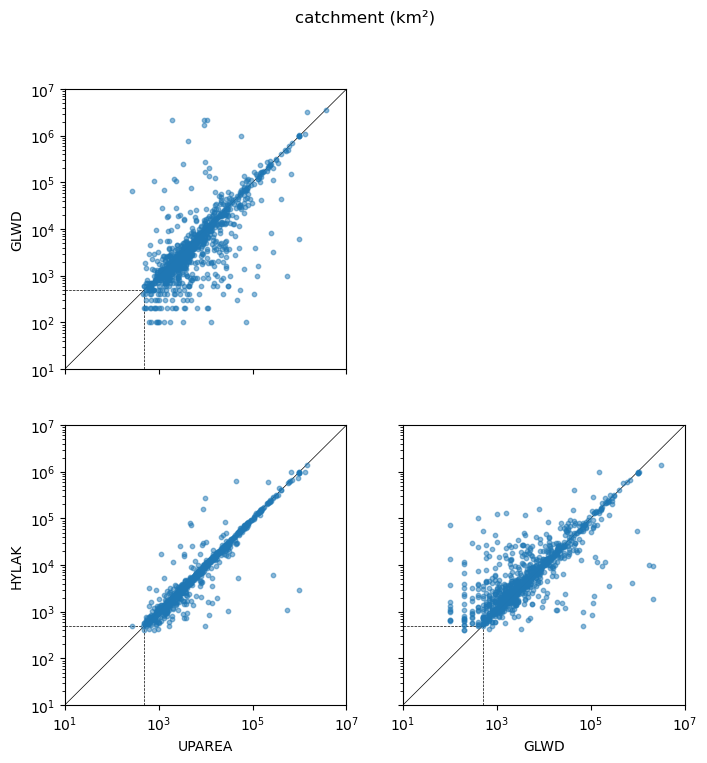

In [16]:
compare_attributes(
    catchment[['UPAREA', 'GLWD', 'HYLAK']],
    thr=MIN_CATCHMENT,
    vmin=10,
    vmax=1e7,
    title='catchment (km²)'
)
plt.savefig(PATH_OUT / 'plots' / 'catchment_pairplot.jpg', dpi=300, bbox_inches='tight')

In [17]:
# error = 10
# mask_error = (catchment.HYLAK < catchment.UPAREA / error) | (catchment.HYLAK > error * catchment.UPAREA)
# print(mask_error.sum())
# catchment[mask_error]

In [18]:
# foo = pd.concat(
#     (glofas5[mask_error][['LAK_ID', 'HYLAK_ID', 'GLWD_ID', 'geometry']],
#      np.round(catchment[mask_error][['UPAREA', 'HYLAK', 'GLWD']], 0)),
#     axis=1
# ).sort_values(['LAK_ID', 'HYLAK_ID'])

# foo.to_file(PATH_OUT / 'errors_area.shp')

#### Select values

In [19]:
# select value from upArea map, HydroLakes or GLWD, in that order
for source in ['HYLAK', 'GLWD', 'UPAREA']:
    missing = catchment.GLOFAS5.isnull()
    mask = catchment[source].notnull()
    catchment.loc[missing & mask, 'GLOFAS5'] = catchment.loc[missing & mask, source]
    catchment.loc[missing & mask, 'SOURCE'] = source
print('{0} reservoirs are missing the catchment value'.format(catchment.GLOFAS5.isnull().sum()))
print('{0} reservoirs have nevative catchment value'.format((catchment.GLOFAS5 < 0).sum()))
catchment.SOURCE.value_counts()

0 reservoirs are missing the catchment value
0 reservoirs have nevative catchment value


HYLAK    991
GLWD      19
Name: SOURCE, dtype: int64

0 reservoirs do not comply with the minimum catchment area of 500 km²


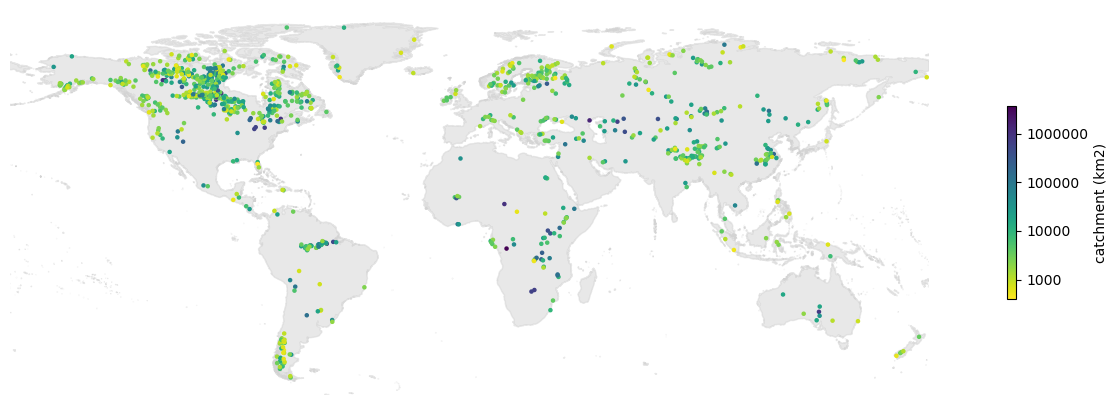

In [20]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=np.log10(catchment.GLOFAS5),
    cmap='viridis_r',
    s=5,
    # vmin=0,
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='catchment (km2)')
ticks = [3, 4, 5, 6]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**x for x in ticks])
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'catchment_map.jpg', dpi=300, bbox_inches='tight')

# add values to GLOFAS5
glofas5.loc[catchment.index, ['CATCH_SKM', 'CATCH_SRC']] = catchment[['GLOFAS5', 'SOURCE']].values
print('{0} reservoirs do not comply with the minimum catchment area of {1} km²'.format((glofas5.CATCH_SKM < MIN_AREA).sum(),
                                                                                       MIN_CATCHMENT))

### Lake area

In [21]:
area = pd.DataFrame(index=glofas5.index, columns=['GLOFAS4', 'GLWD', 'HYLAK', 'GLOFAS5', 'SOURCE'], dtype=float)
area.SOURCE = area.SOURCE.astype(str)

# GLOFAS4
area.loc[glofas4[glofas4.index.notnull()].index, 'GLOFAS4'] = glofas4[glofas4.index.notnull()].AREA_SKM

# GLWD
area.loc[glwd.index, 'GLWD'] = glwd.AREA_SKM

# HydroLakes
area.loc[hylak.index, 'HYLAK'] = hylak.Lake_area

#### Comparison

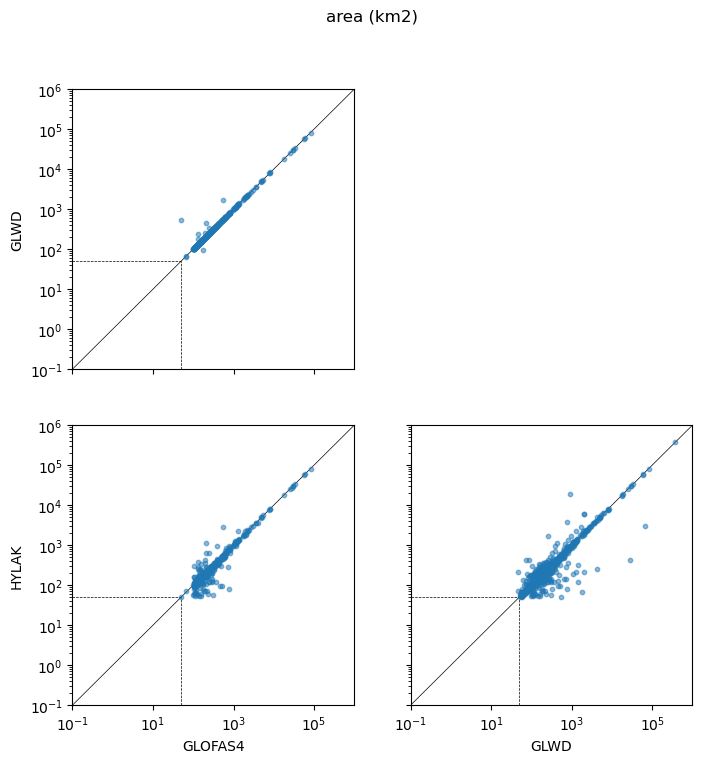

In [22]:
compare_attributes(
    area[['GLOFAS4', 'GLWD', 'HYLAK']],
    thr=MIN_AREA,
    vmin=1e-1,
    vmax=1e6,
    title='area (km2)'
)
plt.savefig(PATH_OUT / 'plots' / 'area_pairplot.jpg', dpi=300, bbox_inches='tight')

In [23]:
# error = 10
# mask_error = (area.HYLAK < area.GLOFAS4 / error) | (area.HYLAK > error * area.GLOFAS4)
# print(mask_error.sum())
# area[mask_error]

#### Select values

I will use HydroLakes as the main source because some GLWD IDs are repeated. This is because HydroLakes considers as a single lake cases that GLWD considers as multiple lakes.

In [24]:
# select value from HydroLakes, GLWD, GLOFAS4 in that order
for source in ['HYLAK', 'GLWD', 'GLOFAS4']:
    missing = area.GLOFAS5.isnull()
    mask = area[source].notnull()
    area.loc[missing & mask, 'GLOFAS5'] = area.loc[missing & mask, source]
    area.loc[missing & mask, 'SOURCE'] = source
print('{0} reservoirs are missing the area value'.format(area.GLOFAS5.isnull().sum()))
print('{0} reservoirs have nevative area value'.format((area.GLOFAS5 < 0).sum()))
area.SOURCE.value_counts()

0 reservoirs are missing the area value
0 reservoirs have nevative area value


HYLAK    991
GLWD      19
Name: SOURCE, dtype: int64

0 lakes do not comply with the minimum lake area of 50 km2


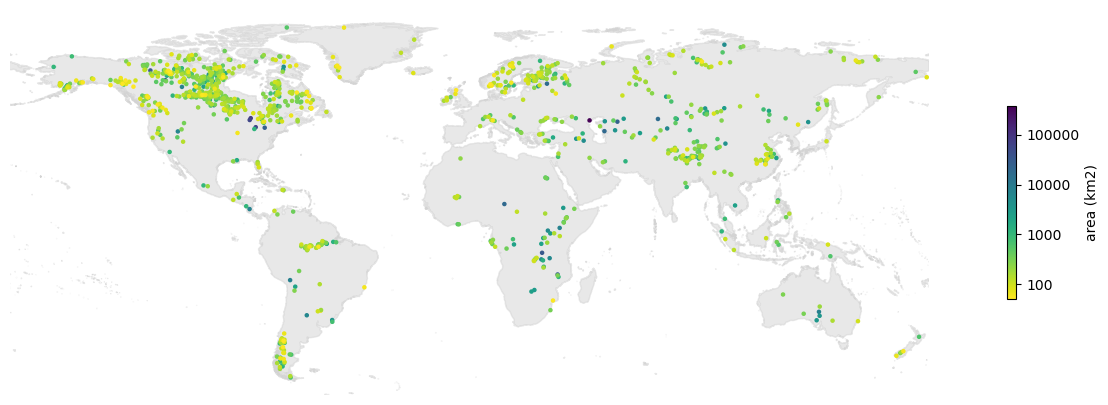

In [25]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=np.log10(area.GLOFAS5),
    cmap='viridis_r',
    s=5,
    # vmin=0,
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='area (km2)')
ticks = [2, 3, 4, 5]
cbar.set_ticks(ticks)
cbar.set_ticklabels([10**x for x in ticks])
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'area_map.jpg', dpi=300, bbox_inches='tight')

# add values to GLOFAS5
glofas5.loc[area.index, ['AREA_SKM', 'AREA_SRC']] = area[['GLOFAS5', 'SOURCE']].values

print('{0} lakes do not comply with the minimum lake area of {1} km2'.format((glofas5.AREA_SKM < MIN_AREA).sum(),
                                                                             MIN_AREA))

### $\alpha$: width of the outlet

In [26]:
alpha = pd.DataFrame(index=glofas5.index, columns=['GLOFAS4', 'BUREK', 'EXP', 'CHANBW', 'GLOFAS5', 'SOURCE'], dtype=float)
alpha.SOURCE = alpha.SOURCE.astype(str)

# GLOFAS4
alpha.loc[glofas4[glofas4.index.notnull()].index, 'GLOFAS4'] = glofas4[glofas4.index.notnull()].ALPHA

# using Burek's formula
alpha['BUREK'] = catchment.UPAREA * 0.0032

# fit a exponential function to the GLOFAS4 data
aux = glofas4[glofas4.ALPHA != glofas4.ALPHA.min()]
params, covariance = curve_fit(width_from_area, aux.CATCH_SKM, aux.ALPHA, p0=[.5])
print('c = {0:.2f}'.format(params[0]))
alpha['EXP'] = width_from_area(catchment.UPAREA, c=params[0])

# # channel width from static maps
# for ID, point in glofas5.geometry.items():
#     alpha.loc[ID, 'CHANBW'] = outlet_width(chanbw, uparea, point.x, point.y, n_points=3)

c = 0.57


#### Comparison 

In [27]:
# fig, axes = plt.subplots(ncols=3, figsize=(10, 3), sharex=True, sharey=True)

# vmin, vmax = .01, 1000
# for ax, col in zip(axes, ['CHANBW', 'BUREK', 'EXP']):
#     ax.scatter(alpha[col], alpha.GLOFAS4, s=8, alpha=.5)
#     ax.plot([vmin, vmax], [vmin, vmax], 'k', lw=.5, zorder=0)
#     ax.set(
#         xlabel=col,
#         xscale='log',
#         yscale='log'
#     )
#     if ax == axes[0]:
#         ax.set_ylabel('GLOFAS4')
#         ax.set(
#             xlim=(vmin, vmax),
#             ylim=(vmin, vmax)
#         )

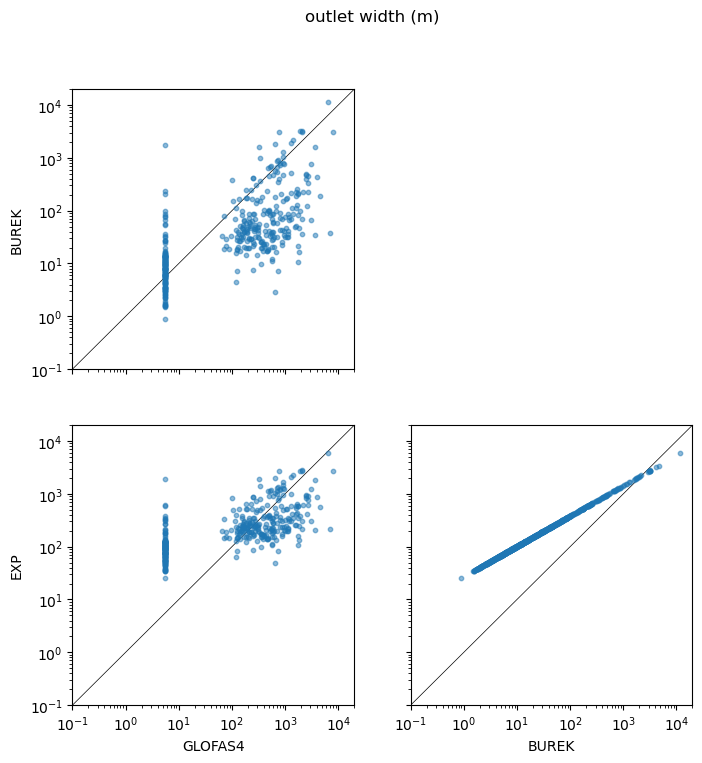

In [28]:
compare_attributes(
    alpha[['GLOFAS4', 'BUREK', 'EXP']],#, 'CHANBW']],
    thr=0,
    vmin=.1,
    vmax=20000,
    title='outlet width (m)'
)
plt.savefig(PATH_OUT / 'plots' / 'outlet_width_pairplot.jpg', dpi=300, bbox_inches='tight')

#### Select values
I select GLOFAS4 values, if possible. If not, I will use the exponential function.

In [29]:
# select value from GRAND, GLOFAS4, HYLAK or ICOLD in that order
for source in ['GLOFAS4', 'EXP']:
    missing = alpha.GLOFAS5.isnull()
    mask = alpha[source].notnull()
    alpha.loc[missing & mask, 'GLOFAS5'] = alpha.loc[missing & mask, source]
    alpha.loc[missing & mask, 'SOURCE'] = source
print('{0} reservoirs are missing the outlet width'.format(alpha.GLOFAS5.isnull().sum()))
print('{0} reservoirs have nevative outlet width'.format((alpha.GLOFAS5 < 0).sum()))
alpha.SOURCE.value_counts()

0 reservoirs are missing the outlet width
0 reservoirs have nevative outlet width


EXP        610
GLOFAS4    400
Name: SOURCE, dtype: int64

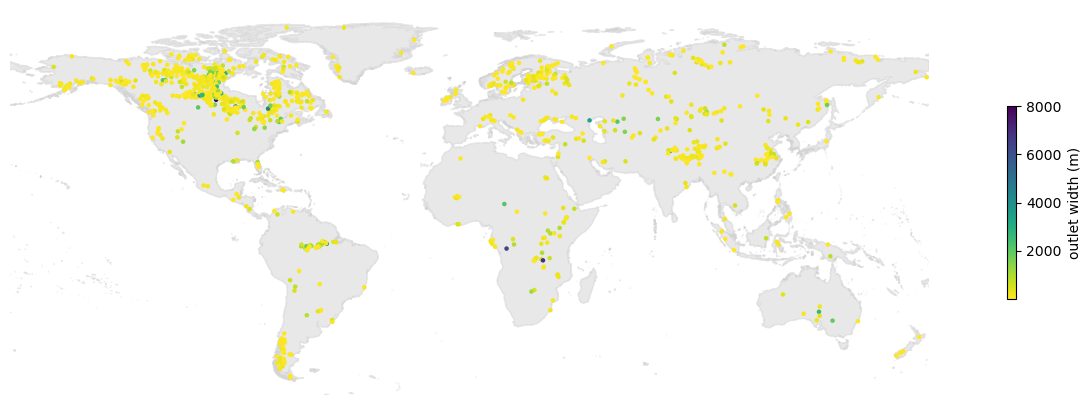

In [30]:
fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=alpha.GLOFAS5,
    cmap='viridis_r',
    s=5,
    # vmin=0,
    # vmax=2.5
)
cbar = plt.colorbar(sct, shrink=.5, label='outlet width (m)')
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'outlet_width_map.jpg', dpi=300, bbox_inches='tight')

# add values to GLOFAS5
glofas5.loc[alpha.index, ['WIDTH_M', 'WIDTH_SRC']] = alpha[['GLOFAS5', 'SOURCE']].values

### Average inflow

In [31]:
dis_avg = pd.DataFrame(index=glofas5.index, columns=['GLOFAS4', 'LTR', 'GLWD', 'HYLAK', 'GLOFAS5', 'SOURCE'], dtype=float)
dis_avg.SOURCE = alpha.SOURCE.astype(str)

# GLOFAS4
dis_avg.loc[glofas4[glofas4.index.notnull()].index, 'GLOFAS4'] = glofas4[glofas4.index.notnull()].AVINFLOW

# GLOFAS4 long-term run
# dis_avg['LTR'] = dis_avg_ltr.sel({'x': poi['x'], 'y': poi['y']}, method='nearest')
dis_avg['LTR'] = extract_timeseries(dis_avg_ltr, poi5.rename({'ID': 'id'}), inflow=True, ldd=ldd).to_pandas()

# GLWD
dis_avg.loc[glwd.index, 'GLWD'] = glwd.INFLOW_CMS

# HydroLakes
dis_avg.loc[hylak.index, 'HYLAK'] = hylak.Dis_avg

#### Comparison

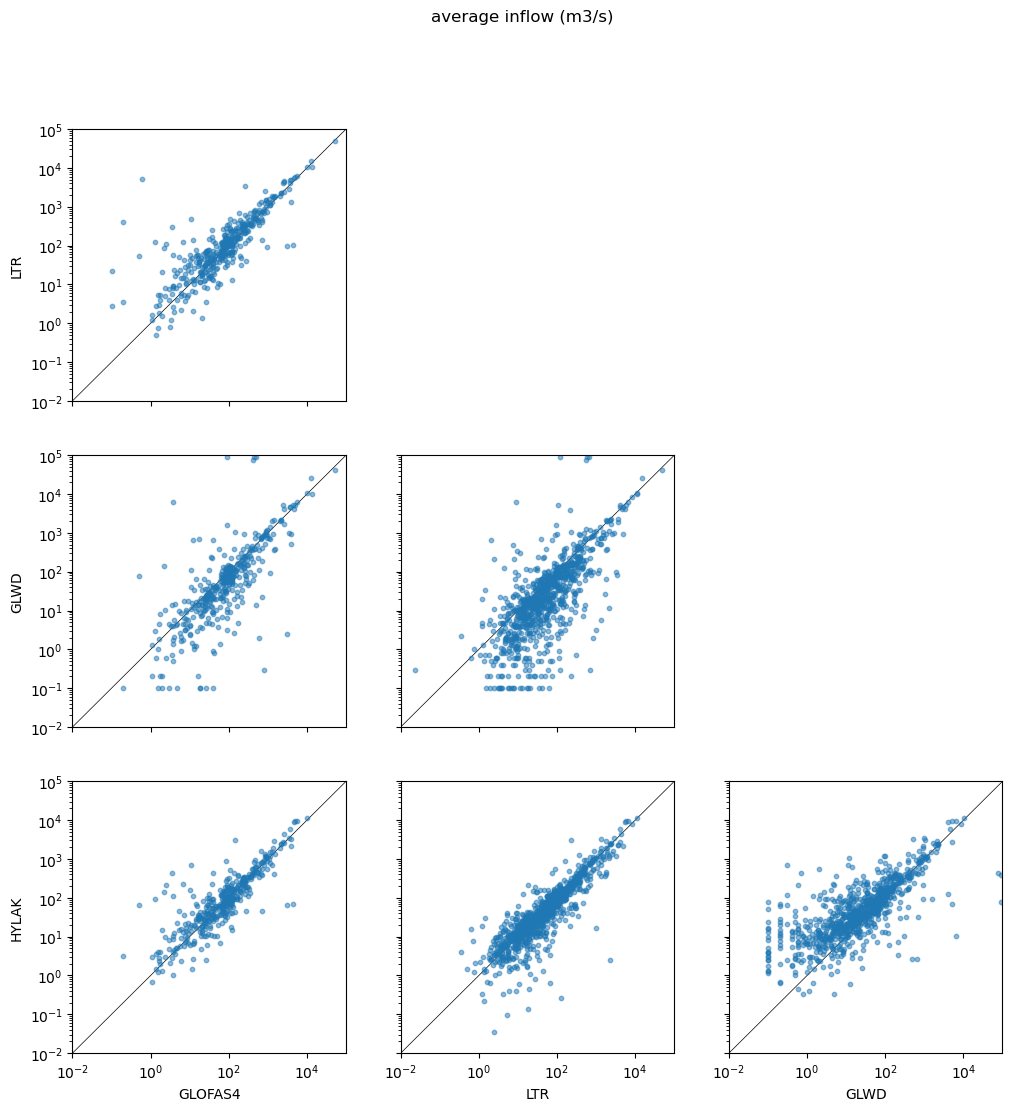

In [32]:
compare_attributes(
    dis_avg[['GLOFAS4', 'LTR', 'GLWD', 'HYLAK']],
    thr=0,
    vmin=0.01,
    vmax=100000,
    title='average inflow (m3/s)'
)
plt.savefig(PATH_OUT / 'plots' / 'dis_avg_pairplot.jpg', dpi=300, bbox_inches='tight')

#### Select value

I will select in all cases the value from the GLOFAS4 long-term run.

12 reservoirs have an average inflow below 1 m3/s


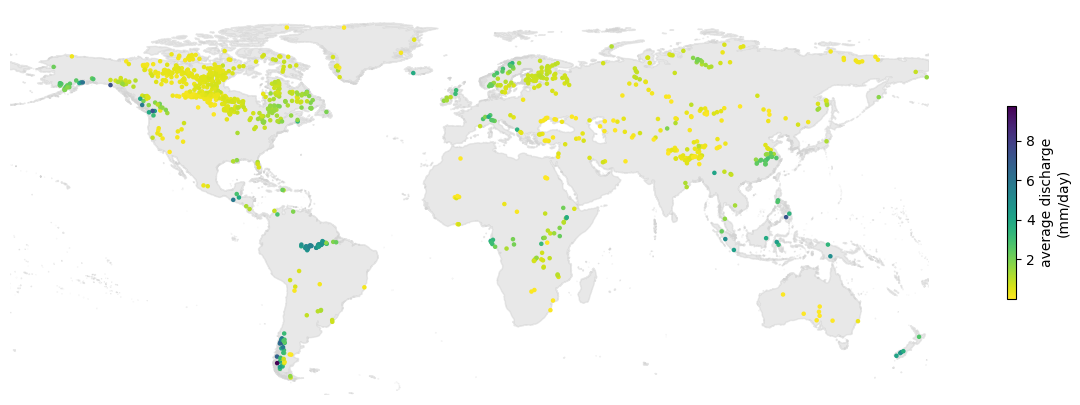

In [33]:
# select values from the GLOFAS4 long-term run
dis_avg.GLOFAS5 = dis_avg.LTR
dis_avg.SOURCE = 'GLOFAS4_ltr'

fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
sct = ax.scatter(
    glofas5.geometry.x,
    glofas5.geometry.y,
    c=dis_avg.GLOFAS5 / catchment.UPAREA * 3.6 * 24,
    cmap='viridis_r',
    s=5,
)
cbar = plt.colorbar(sct, shrink=.5, label='average discharge\n(mm/day)')
plt.axis('off');
plt.savefig(PATH_OUT / 'plots' / 'dis_avg_map.jpg', dpi=300, bbox_inches='tight')

# add values to GLOFAS5
glofas5.loc[alpha.index, ['DISAVG_CMS', 'DIS_SRC']] = dis_avg[['GLOFAS5', 'SOURCE']].values
print('{0} reservoirs have an average inflow below 1 m3/s'.format((glofas5.DISAVG_CMS < 1).sum()))

## Export

### Excel file

#### Lakes

In [35]:
lakes = glofas5.copy()

# add coordinates in the LISFLOOD grid
lakes['LisfloodX'] = lakes.geometry.x
lakes['LisfloodY'] = lakes.geometry.y

# add info from HydroLakes
hylak_ids = lakes.HYLAK_ID.dropna()
hylak_cols = {'Lake_name': 'LAKE_NAME', 
              'Country': 'COUNTRY',
              'Pour_long': 'LONG_DD',
              'Pour_lat': 'LAT_DD'}
# lakes.loc[hylak_ids.index, hylak_cols.values()] = hylak.loc[hylak.Hylak_id.isin(hylak_ids.values), hylak_cols].rename(columns=hylak_cols).values
lakes = pd.concat((lakes, hylak.loc[hylak.Hylak_id.isin(hylak_ids.values), hylak_cols].rename(columns=hylak_cols)), axis=1)

# reorder columns
cols = ['LAK_ID', 'RES_ID', 'GLWD_ID', 'HYLAK_ID', 'GRAND_ID', 'INT_CODE',
        'LAKE_NAME', 'COUNTRY', 
        'LONG_DD', 'LAT_DD', 'LisfloodX', 'LisfloodY', 
        'CATCH_SKM', 'CATCH_SRC', 'AREA_SKM', 'AREA_SRC', 'WIDTH_M', 'WIDTH_SRC', 'DISAVG_CMS', 'DIS_SRC']
lakes = lakes[lakes.columns.intersection(cols)]

#### Reservoirs as lakes

In [36]:
# compute outlet widht of reservoirs
reservoirs['WIDTH_M'] = width_from_area(reservoirs.CATCH_SKM, c=params[0])
reservoirs['WIDTH_SRC'] = 'EXP'
# rename and reorder columns
reservoirs.rename(columns={'RES_NAME': 'LAKE_NAME'}, inplace=True, errors='ignore')
reservoirs = reservoirs[reservoirs.columns.intersection(cols)]

#### Combination

In [37]:
# merge
lakes_reservoirs = pd.concat((lakes, reservoirs), axis=0)[cols]
lakes_reservoirs.sort_values(['LAK_ID', 'RES_ID'], inplace=True)

# reset index
# reservoirs['FID'] = np.arange(1, reservoirs.shape[0] + 1)
# reservoirs.loc[reservoirs.ResID > 5000, 'FID'] = reservoirs.loc[reservoirs.ResID > 5000, 'ResID']
idx = []
i = glofas4.LAK_ID.max()
for lak_id in lakes_reservoirs.LAK_ID.values:
    if pd.isna(lak_id):
        i += 1
        idx.append(i)
    else:
        idx.append(lak_id)
lakes_reservoirs['FID'] = idx
lakes_reservoirs.set_index('FID', drop=True, inplace=True)
lakes_reservoirs.sort_index(axis=0, inplace=True)

# export
xls_file = PATH_OUT / 'glofas5_lakes_{0}.xlsx'.format(datetime.now().strftime('%Y%m%d'))
lakes_reservoirs.to_excel(xls_file, float_format='%.4f')
print(f'Lake Excel table saved in : {xls_file}')

### TXT tables 

In [38]:
# table lake area
(lakes_reservoirs.AREA_SKM * 1000000).to_csv(
    PATH_OUT / 'lakes_glofas5_area_{0}.txt'.format(datetime.now().strftime('%Y%m%d')),
    sep='\t',
    header=None,
    float_format='%.0f'
)

# table average inflow
lakes_reservoirs.DISAVG_CMS.round(1).to_csv(
    PATH_OUT / 'lakes_glofas5_avg_inflow_{0}.txt'.format(datetime.now().strftime('%Y%m%d')),
    sep='\t',
    header=None
)

# table alpha parameter
lakes_reservoirs.WIDTH_M.round(1).to_csv(
    PATH_OUT / 'lakes_glofas5_alpha_{0}.txt'.format(datetime.now().strftime('%Y%m%d')),
    sep='\t',
    header=None
)

### NetCDF map

In [39]:
# load map from GloFAS4
template = rxr.open_rasterio('Z:/nahaUsers/grimast/GloFASv5_template/template_Global_03min.nc')#.squeeze(dim='band').astype(int)
template.close()

# remove all values
template[:,:] = 0

# assign IDs of lakes in GloFAS5
for ID, row in tqdm(lakes_reservoirs.iterrows(), total=len(lakes_reservoirs)):
    pixel = template.sel({'x': row.LisfloodX, 'y': row.LisfloodY}, method='nearest')
    template.loc[{'x': pixel.x.item(), 'y': pixel.y.item()}] = ID

# modify attributes
template.attrs['contributors'] = ('Juliana Disperati <juliana.disperati@ext.ec.europa.eu>', 'Stefania Grimaldi <stefania.grimaldi@ec.europa.eu>')
template.attrs['creator'] = 'Jesús Casado Rodríguez <jesus.casado-rodriguez@ec.europa.eu>'
template.attrs['creator_name'] = 'casadje'
template.attrs['history'] = ('Created {0}'.format(datetime.now().strftime("%a %b %e %H:%M:%S %Y")))
template.attrs['history_of_appended_files'] = ''
template.attrs['institution'] = 'Joint Research Centre - European Commission'
template.attrs['references'] = (
    'https://www.hydrosheds.org/products/hydrolakes', 
    'https://www.hydrosheds.org/products/glwd'
)

# define coordinate reference system
template = template.rio.write_crs('EPSG:4326')

# export NetCDF map
template.rio.to_raster(PATH_OUT / 'lakes_glofas5_03min_{0}.nc'.format(datetime.now().strftime('%Y%m%d')))

  0%|          | 0/1230 [00:00<?, ?it/s]